# Tutorial 20: Startup Shear with Spatial Stress Localization (FluiditySaramitoNonlocal)

## Learning Objectives

This notebook demonstrates startup shear flow analysis using the FluiditySaramitoNonlocal model with **spatial resolution** across the Couette gap:

1. **Spatial Stress Tensor Evolution**: Track τ_xy(y,t), N₁(y,t) across gap during startup transient
2. **Stress Localization Dynamics**: Observe how stress concentrates near moving boundary
3. **Shear Banding Detection**: Identify localized flow bands via fluidity profile f(y)
4. **Normal Stress Heterogeneity**: See how N₁ varies spatially due to local shear rate gradients
5. **Cooperativity Length ξ**: Understand how ξ controls interface width between bands
6. **NLSQ + Bayesian Calibration**: Fit bulk stress σ(t) while inferring spatial parameters (ξ)
7. **Band Width Analysis**: Quantify flowing fraction and band interface thickness

**Key Physics**: Nonlocal diffusion (D_f = ξ²/t_a) regularizes fluidity evolution, enabling finite-width shear band interfaces. During startup, the model predicts whether flow localizes near the moving wall or remains homogeneous across the gap.

**Experimental Connection**: Velocity profiles v(y,t) from particle tracking or ultrasound velocimetry can validate spatial predictions.

## Google Colab Setup

Run this cell if using Google Colab to install RheoJAX:

In [1]:
# Uncomment and run in Google Colab
# !pip install rheojax jaxopt optax arviz

## Setup and Imports

In [2]:
import os
import sys

%matplotlib inline
# JAX float64 configuration (CRITICAL: must come before any JAX imports)
# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax
from rheojax.utils.metrics import compute_fit_quality

jax, jnp = safe_import_jax()

# Standard imports
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from rheojax.core.data import RheoData
from rheojax.logging import configure_logging, get_logger

# RheoJAX imports
from rheojax.models.fluidity import FluiditySaramitoNonlocal

# Bayesian inference

# Configure logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Plot styling
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11

print(f"JAX version: {jax.__version__}")
print(f"JAX devices: {jax.devices()}")
print(f"Float64 enabled: {jax.config.jax_enable_x64}")
# Flag for conditional Bayesian sections
bayesian_completed = False


JAX version: 0.8.3
JAX devices: [CpuDevice(id=0)]
Float64 enabled: True


## Theory: Nonlocal Startup with Spatial Resolution

### Governing Equations (1D Couette)

The FluiditySaramitoNonlocal model extends the local version with spatial diffusion across the gap (y-direction):

1. **Bulk Stress Evolution** (gap-averaged):
   $$\frac{d\Sigma}{dt} = G\left(\dot{\gamma} - \Sigma \langle f \rangle_y\right)$$
   
   where $\langle f \rangle_y = \frac{1}{H}\int_0^H f(y,t) dy$ is the spatially-averaged fluidity.

2. **Fluidity Field Evolution** (PDE in y):
   $$\frac{\partial f}{\partial t} = \underbrace{\frac{f_{age} - f}{t_a}}_{\text{aging}} + \underbrace{b|\dot{\gamma}_y|^{n_r}(f_{flow} - f)}_{\text{rejuvenation}} + \underbrace{\frac{\xi^2}{t_a}\frac{\partial^2 f}{\partial y^2}}_{\text{nonlocal diffusion}}$$

3. **Local Shear Rate** (from force balance):
   $$\dot{\gamma}_y(y,t) = \alpha(y) f(y,t) \Sigma(t)$$
   
   where $\alpha = \max(0, 1 - \tau_y/|\Sigma|)$ is the plasticity factor.

### Startup Protocol

- **Initial Condition**: $f(y,0) = f_{age}$ (uniform aged state), $\Sigma(0) = 0$
- **Imposed Rate**: Step to constant $\dot{\gamma}$ at wall (gap-averaged)
- **Spatial Response**: $f(y,t)$ develops gradients, stress concentrates near moving wall

### Stress Localization vs Homogeneous Flow

**Localization Criterion**: When local fluidity gradient $\nabla f$ grows faster than diffusion smooths it:
$$\text{Pe} = \frac{\dot{\gamma} H}{\xi^2/t_a} \gg 1 \quad \Rightarrow \quad \text{Shear banding}$$

**Small ξ** (weak diffusion): Sharp bands with interface width $\sim \xi$

**Large ξ** (strong diffusion): Smooth gradient, no distinct bands

### Normal Stress Spatial Profile

From the UCM backbone:
$$N_1(y,t) = 2\lambda(f(y)) \dot{\gamma}_y(y,t) \tau_{xy}(y,t)$$

where $\lambda = 1/f$. High fluidity zones → low $\lambda$ → lower N₁ contribution.

### Key Observables

1. **Bulk Overshoot**: $\Sigma(t)$ shows stress overshoot as in local model
2. **Fluidity Profile**: $f(y,t_{steady})$ reveals band structure
3. **Band Width**: Flowing fraction = $\int_{y: \dot{\gamma}_y > 0.1\dot{\gamma}_{max}} dy / H$
4. **Interface Thickness**: $\delta \sim \xi$ where $\nabla f$ is maximum
5. **N₁ Localization**: Normal stress concentrated where $\dot{\gamma}_y$ is large

## Load Calibrated Parameters (or Use Defaults)

Try to load from flow curve calibration (Tutorial 19). Otherwise, use sensible defaults.

In [3]:
# Try to load from flow curve calibration
param_file = Path("../outputs/fluidity/saramito_nonlocal/flow_curve/parameters_nlsq.txt")

if param_file.exists():
    logger.info(f"Loading calibrated parameters from {param_file}")
    params = {}
    with open(param_file) as f:
        for line in f:
            if '=' in line and not line.strip().startswith('#'):
                key, val = line.split('=')
                params[key.strip()] = float(val.strip())
    
    G = params.get('G', 1000.0)
    tau_y0 = params.get('tau_y0', 50.0)
    K_HB = params.get('K_HB', 10.0)
    n_HB = params.get('n_HB', 0.5)
    # Clamp f_age to model bounds (1e-12, 1e-2)
    f_age = min(params.get('f_age', 0.01), 0.01)
    f_flow = params.get('f_flow', 1.0)
    t_a = params.get('t_a', 10.0)
    b = params.get('b', 0.5)
    n_rej = params.get('n_rej', 1.0)
    xi = params.get('xi', 1e-5)
    
    logger.info(f"Loaded: G={G:.1f}, τ_y={tau_y0:.1f}, ξ={xi:.2e}")
else:
    logger.info("No calibrated parameters found, using defaults")
    # Default parameters for demonstration
    G = 1000.0        # Elastic modulus (Pa)
    tau_y0 = 50.0     # Yield stress (Pa)
    K_HB = 10.0       # HB consistency (Pa·s^n)
    n_HB = 0.5        # HB exponent
    f_age = 0.01      # Aging fluidity (1/(Pa·s))
    f_flow = 1.0      # Flow fluidity (1/(Pa·s))
    t_a = 10.0        # Aging time (s)
    b = 0.5           # Rejuvenation amplitude
    n_rej = 1.0       # Rejuvenation exponent
    xi = 1e-5         # Cooperativity length (m)

# Spatial discretization
N_y = 51              # Grid points across gap
H = 1e-3              # Gap width (1 mm)

print("\n=== Model Parameters ===")
print(f"G (elastic modulus): {G:.1f} Pa")
print(f"τ_y0 (yield stress): {tau_y0:.1f} Pa")
print(f"K_HB: {K_HB:.1f} Pa·s^n")
print(f"n_HB: {n_HB:.2f}")
print(f"f_age: {f_age:.3f} (1/(Pa·s))")
print(f"f_flow: {f_flow:.3f} (1/(Pa·s))")
print(f"t_a: {t_a:.1f} s")
print(f"b: {b:.2f}")
print(f"n_rej: {n_rej:.2f}")
print(f"ξ (cooperativity): {xi:.2e} m")
print(f"\nN_y (grid points): {N_y}")
print(f"H (gap width): {H*1e3:.1f} mm")
print(f"dy (grid spacing): {H/(N_y-1)*1e6:.2f} μm")


=== Model Parameters ===
G (elastic modulus): 1000.0 Pa
τ_y0 (yield stress): 50.0 Pa
K_HB: 10.0 Pa·s^n
n_HB: 0.50
f_age: 0.010 (1/(Pa·s))
f_flow: 1.000 (1/(Pa·s))
t_a: 10.0 s
b: 0.50
n_rej: 1.00
ξ (cooperativity): 1.00e-05 m

N_y (grid points): 51
H (gap width): 1.0 mm
dy (grid spacing): 20.00 μm


## Generate Synthetic Startup Data with Spatial Resolution

Simulate startup shear at constant rate, tracking spatial stress and fluidity evolution.

In [4]:
# Create model for data generation
model_true = FluiditySaramitoNonlocal(
    coupling="minimal",  # Use minimal for faster simulation
    N_y=N_y,
    H=H,
    xi=xi
)

# Set true parameters
model_true.parameters['G'].value = G
model_true.parameters['tau_y0'].value = tau_y0
model_true.parameters['K_HB'].value = K_HB
model_true.parameters['n_HB'].value = n_HB
model_true.parameters['f_age'].value = f_age
model_true.parameters['f_flow'].value = f_flow
model_true.parameters['t_a'].value = t_a
model_true.parameters['b'].value = b
model_true.parameters['n_rej'].value = n_rej
model_true.parameters['xi'].value = xi

# Startup simulation parameters
gamma_dot_startup = 1.0  # Applied shear rate (1/s)
t_end = 100.0            # Simulation time (s)
n_points = 200           # Time points

# Generate time array (log spacing for overshoot resolution)
t_startup = np.logspace(-2, np.log10(t_end), n_points)

# Simulate startup (returns time, bulk stress, final fluidity field)
logger.info(f"Simulating nonlocal startup at γ̇ = {gamma_dot_startup:.2f} 1/s...")
_, sigma_bulk_true, f_field_final = model_true.simulate_startup(
    t_startup,
    gamma_dot=gamma_dot_startup
)

# Add realistic noise to bulk stress (5% relative)
np.random.seed(42)
noise_level = 0.05
noise = noise_level * np.abs(sigma_bulk_true) * np.random.randn(len(sigma_bulk_true))
sigma_bulk_noisy = sigma_bulk_true + noise

# Spatial grid
y_grid = model_true.y_grid

print(f"✓ Simulation complete: {len(t_startup)} time points, {N_y} spatial points")

✓ Simulation complete: 200 time points, 51 spatial points


## Visualize Bulk Stress Response

First, examine the gap-averaged (bulk) stress that would be measured experimentally.

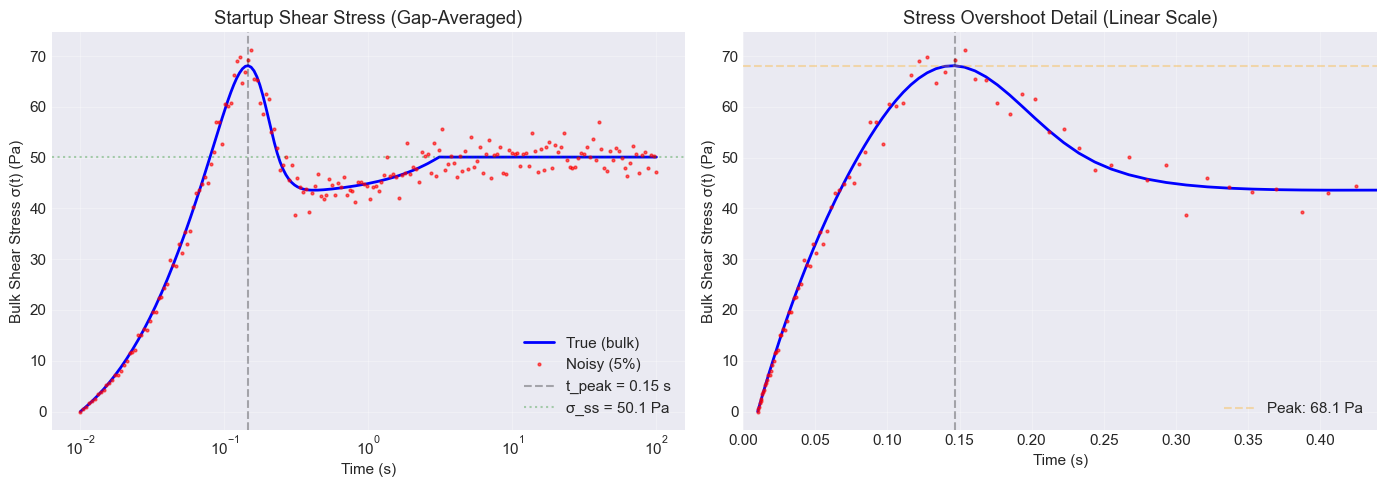


=== Bulk Stress Characteristics ===
Peak stress: 68.09 Pa at t = 0.146 s
Steady-state stress: 50.10 Pa
Overshoot ratio: 1.36


In [5]:
# Find overshoot peak
peak_idx = np.argmax(sigma_bulk_true)
t_peak = t_startup[peak_idx]
sigma_peak = sigma_bulk_true[peak_idx]
sigma_steady = sigma_bulk_true[-1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bulk stress evolution
axes[0].plot(t_startup, sigma_bulk_true, 'b-', linewidth=2, label='True (bulk)')
axes[0].plot(t_startup, sigma_bulk_noisy, 'r.', markersize=4, alpha=0.6, label='Noisy (5%)')
axes[0].axvline(t_peak, color='k', linestyle='--', alpha=0.3, label=f't_peak = {t_peak:.2f} s')
axes[0].axhline(sigma_steady, color='g', linestyle=':', alpha=0.3, label=f'σ_ss = {sigma_steady:.1f} Pa')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Bulk Shear Stress σ(t) (Pa)')
axes[0].set_xscale('log')
axes[0].set_title('Startup Shear Stress (Gap-Averaged)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Linear scale for overshoot detail
axes[1].plot(t_startup, sigma_bulk_true, 'b-', linewidth=2)
axes[1].plot(t_startup, sigma_bulk_noisy, 'r.', markersize=4, alpha=0.6)
axes[1].axvline(t_peak, color='k', linestyle='--', alpha=0.3)
axes[1].axhline(sigma_peak, color='orange', linestyle='--', alpha=0.3, label=f'Peak: {sigma_peak:.1f} Pa')
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Bulk Shear Stress σ(t) (Pa)')
axes[1].set_title('Stress Overshoot Detail (Linear Scale)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xlim([0, min(t_peak * 3, t_end)])

plt.tight_layout()
plt.show()
plt.close('all')

print("\n=== Bulk Stress Characteristics ===")
print(f"Peak stress: {sigma_peak:.2f} Pa at t = {t_peak:.3f} s")
print(f"Steady-state stress: {sigma_steady:.2f} Pa")
print(f"Overshoot ratio: {sigma_peak/sigma_steady:.2f}")

## Spatial Fluidity Profile: Shear Band Detection

Examine the final fluidity field f(y) to detect stress localization.

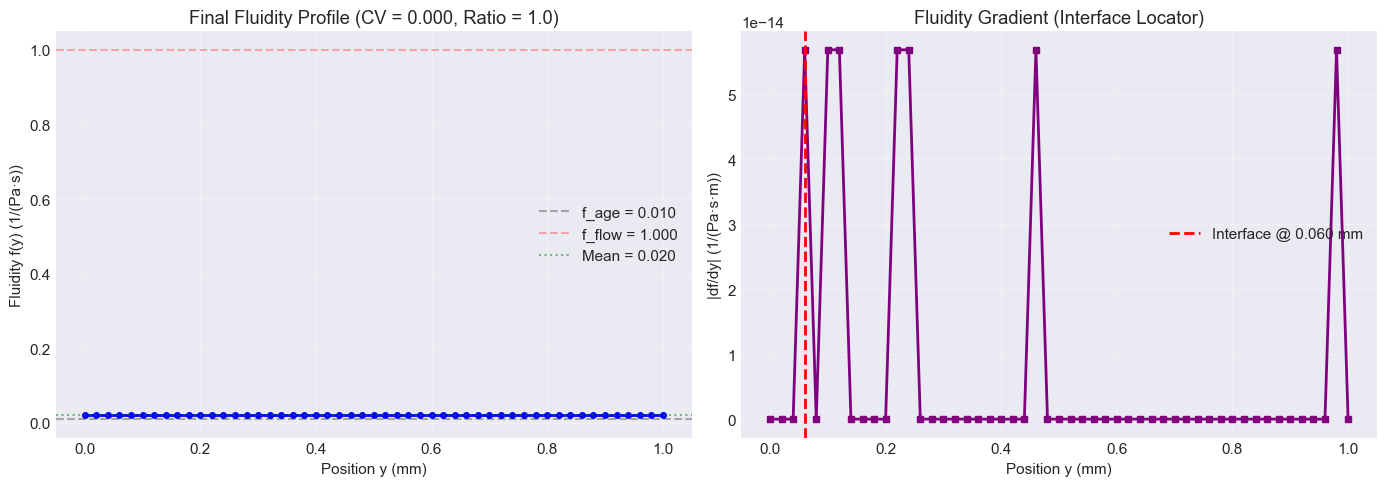


=== Shear Banding Analysis ===
Banding detected: NO (CV > 0.3 threshold)
Coefficient of Variation (CV): 0.0000
Max/Min fluidity ratio: 1.00
Flowing band fraction: 0.00%
f_max: 0.0200, f_min: 0.0200
Interface position: 0.060 mm (6.0% across gap)
Interface width δ ≈ 140.0 μm (cf. ξ = 10.0 μm)


In [6]:
# Detect shear banding
is_banded, cv, ratio = model_true.detect_shear_bands(f_field_final, threshold=0.3)
metrics = model_true.get_banding_metrics(f_field_final)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fluidity profile across gap
axes[0].plot(y_grid * 1e3, f_field_final, 'b-', linewidth=2, marker='o', markersize=4)
axes[0].axhline(f_age, color='k', linestyle='--', alpha=0.3, label=f'f_age = {f_age:.3f}')
axes[0].axhline(f_flow, color='r', linestyle='--', alpha=0.3, label=f'f_flow = {f_flow:.3f}')
axes[0].axhline(metrics['f_mean'], color='g', linestyle=':', alpha=0.5, label=f'Mean = {metrics["f_mean"]:.3f}')
axes[0].set_xlabel('Position y (mm)')
axes[0].set_ylabel('Fluidity f(y) (1/(Pa·s))')
axes[0].set_title(f'Final Fluidity Profile (CV = {cv:.3f}, Ratio = {ratio:.1f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Fluidity gradient (interface detection)
df_dy = np.gradient(f_field_final, y_grid)
axes[1].plot(y_grid * 1e3, np.abs(df_dy), 'purple', linewidth=2, marker='s', markersize=4)
axes[1].set_xlabel('Position y (mm)')
axes[1].set_ylabel('|df/dy| (1/(Pa·s·m))')
axes[1].set_title('Fluidity Gradient (Interface Locator)')
axes[1].grid(True, alpha=0.3)

# Mark interface (maximum gradient)
interface_idx = np.argmax(np.abs(df_dy))
y_interface = y_grid[interface_idx]
axes[1].axvline(y_interface * 1e3, color='r', linestyle='--', linewidth=2, 
                label=f'Interface @ {y_interface*1e3:.3f} mm')
axes[1].legend()

plt.tight_layout()
plt.show()
plt.close('all')

print("\n=== Shear Banding Analysis ===")
print(f"Banding detected: {'YES' if is_banded else 'NO'} (CV > 0.3 threshold)")
print(f"Coefficient of Variation (CV): {cv:.4f}")
print(f"Max/Min fluidity ratio: {ratio:.2f}")
print(f"Flowing band fraction: {metrics['band_fraction']:.2%}")
print(f"f_max: {metrics['f_max']:.4f}, f_min: {metrics['f_min']:.4f}")
print(f"Interface position: {y_interface*1e3:.3f} mm ({y_interface/H:.1%} across gap)")

# Estimate interface width (where gradient > 50% of max)
grad_threshold = 0.5 * np.max(np.abs(df_dy))
interface_mask = np.abs(df_dy) > grad_threshold
if np.any(interface_mask):
    interface_width = np.sum(interface_mask) * (y_grid[1] - y_grid[0])
    print(f"Interface width δ ≈ {interface_width*1e6:.1f} μm (cf. ξ = {xi*1e6:.1f} μm)")

## Spatial Stress Distribution: τ_xy(y) and N₁(y)

Compute local stress components from the fluidity field (requires reconstruction from force balance).

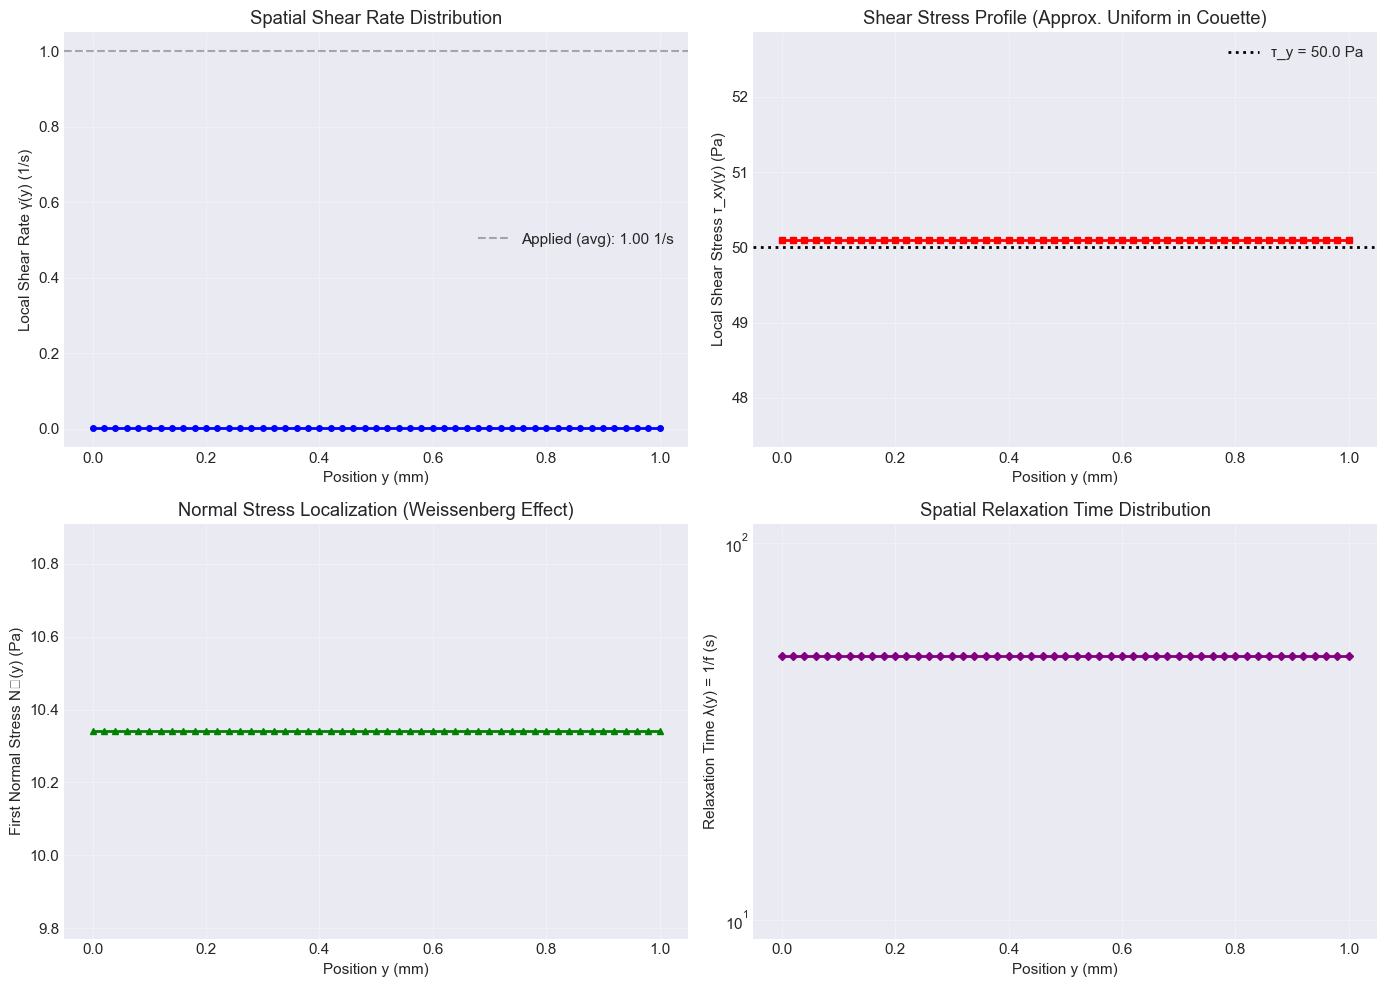


=== Spatial Stress Statistics ===
γ̇_max: 0.002 1/s at y = 0.000 mm
γ̇_min: 0.002 1/s at y = 0.000 mm
γ̇ heterogeneity: 1.00

N₁_max: 10.34 Pa
N₁_min: 10.34 Pa
N₁ heterogeneity: 1.00


In [7]:
# Reconstruct local shear rate from force balance
# In Couette: σ ≈ const across gap, so γ̇(y) = α(y) * f(y) * σ
sigma_final = sigma_bulk_true[-1]
alpha = np.clip(1.0 - tau_y0 / (np.abs(sigma_final) + 1e-20), 0.0, 1.0)  # Scalar for simplicity
gamma_dot_local = alpha * f_field_final * sigma_final

# Local shear stress (approximately uniform in Couette)
tau_xy_local = np.ones_like(f_field_final) * sigma_final

# Local first normal stress difference (UCM approximation)
# N₁ = 2λ γ̇ τ_xy, where λ = 1/f
lambda_local = 1.0 / (f_field_final + 1e-20)
N1_local = 2.0 * lambda_local * gamma_dot_local * tau_xy_local

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Local shear rate
axes[0, 0].plot(y_grid * 1e3, gamma_dot_local, 'b-', linewidth=2, marker='o', markersize=4)
axes[0, 0].axhline(gamma_dot_startup, color='k', linestyle='--', alpha=0.3, 
                   label=f'Applied (avg): {gamma_dot_startup:.2f} 1/s')
axes[0, 0].set_xlabel('Position y (mm)')
axes[0, 0].set_ylabel('Local Shear Rate γ̇(y) (1/s)')
axes[0, 0].set_title('Spatial Shear Rate Distribution')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Local shear stress
axes[0, 1].plot(y_grid * 1e3, tau_xy_local, 'r-', linewidth=2, marker='s', markersize=4)
axes[0, 1].axhline(tau_y0, color='k', linestyle=':', linewidth=2, label=f'τ_y = {tau_y0:.1f} Pa')
axes[0, 1].set_xlabel('Position y (mm)')
axes[0, 1].set_ylabel('Local Shear Stress τ_xy(y) (Pa)')
axes[0, 1].set_title('Shear Stress Profile (Approx. Uniform in Couette)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Normal stress N₁
axes[1, 0].plot(y_grid * 1e3, N1_local, 'g-', linewidth=2, marker='^', markersize=4)
axes[1, 0].set_xlabel('Position y (mm)')
axes[1, 0].set_ylabel('First Normal Stress N₁(y) (Pa)')
axes[1, 0].set_title('Normal Stress Localization (Weissenberg Effect)')
axes[1, 0].grid(True, alpha=0.3)

# Relaxation time λ(y)
axes[1, 1].plot(y_grid * 1e3, lambda_local, 'purple', linewidth=2, marker='D', markersize=4)
axes[1, 1].set_xlabel('Position y (mm)')
axes[1, 1].set_ylabel('Relaxation Time λ(y) = 1/f (s)')
axes[1, 1].set_title('Spatial Relaxation Time Distribution')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()
plt.close('all')

print("\n=== Spatial Stress Statistics ===")
print(f"γ̇_max: {np.max(gamma_dot_local):.3f} 1/s at y = {y_grid[np.argmax(gamma_dot_local)]*1e3:.3f} mm")
print(f"γ̇_min: {np.min(gamma_dot_local):.3f} 1/s at y = {y_grid[np.argmin(gamma_dot_local)]*1e3:.3f} mm")
print(f"γ̇ heterogeneity: {np.max(gamma_dot_local)/np.min(gamma_dot_local):.2f}")
print(f"\nN₁_max: {np.max(N1_local):.2f} Pa")
print(f"N₁_min: {np.min(N1_local):.2f} Pa")
print(f"N₁ heterogeneity: {np.max(N1_local)/(np.min(N1_local)+1e-10):.2f}")

## NLSQ Fitting: Calibrate Parameters from Bulk Stress

Fit the model to the gap-averaged (experimentally accessible) stress σ(t).

In [8]:
# Create fresh model for fitting (use coarser grid for speed)
model = FluiditySaramitoNonlocal(
    coupling="minimal",
    N_y=31,  # Coarser grid for fitting (31 vs 51)
    H=H,
    xi=xi
)

# Set initial guesses (slightly perturbed, but respect bounds)
model.parameters['G'].value = G * 0.9
model.parameters['tau_y0'].value = tau_y0 * 1.1
model.parameters['K_HB'].value = K_HB * 0.95
model.parameters['n_HB'].value = n_HB
# Clamp f_age to stay within bounds (upper bound is 0.01)
model.parameters['f_age'].value = min(f_age * 1.05, 0.01)
model.parameters['f_flow'].value = f_flow * 0.98
model.parameters['t_a'].value = t_a * 1.02
model.parameters['b'].value = b
model.parameters['n_rej'].value = n_rej
model.parameters['xi'].value = xi * 1.1

# Fit with NLSQ
logger.info("Starting NLSQ optimization for nonlocal startup data...")
logger.info("(Using coarser spatial grid for faster optimization)")

model.fit(
    t_startup,
    sigma_bulk_noisy,
    test_mode='startup',
    gamma_dot=gamma_dot_startup,
    max_iter=3000,
    ftol=1e-6,
    xtol=1e-6,
    method='scipy'
)

# Compute fit quality
sigma_fit_initial = model.predict(t_startup, test_mode='startup', gamma_dot=gamma_dot_startup)
metrics_nlsq = compute_fit_quality(sigma_bulk_noisy, sigma_fit_initial)

print(f"\n=== NLSQ Fitting Results ===")
print(f"R²: {metrics_nlsq['R2']:.6f}")
print(f"RMSE: {metrics_nlsq['RMSE']:.4e}")

print("\n=== Fitted Parameters ===")
for name, param in model.parameters.items():
    true_val = model_true.parameters[name].value
    error = 100 * abs(param.value - true_val) / (true_val + 1e-10)
    print(f"{name:12s}: {param.value:12.6e}  (true: {true_val:12.6e}, error: {error:6.2f}%)")

# Restore fine grid for prediction
model.N_y = N_y
model.dy = H / (N_y - 1)

19:01:59 | INFO     | rheojax.models.fluidity.saramito.nonlocal_model | model_fit started


19:01:59 | INFO     | rheojax.utils.optimization | Using SciPy least_squares directly (method='scipy') | n_params=11


19:02:12 | INFO     | rheojax.models.fluidity.saramito.nonlocal_model | model_fit completed


19:02:12 | INFO     | rheojax.core.base | Fit completed | model=FluiditySaramitoNonlocal | fitted=True | R2=0.9065 | data_shape=(200,)



=== NLSQ Fitting Results ===
R²: 0.906503
RMSE: 4.7977e+00

=== Fitted Parameters ===
G           : 9.000151e+02  (true: 1.000000e+03, error:  10.00%)
eta_s       : 1.000000e-10  (true: 0.000000e+00, error: 100.00%)
tau_y0      : 5.500009e+01  (true: 5.000000e+01, error:  10.00%)
K_HB        : 9.500000e+00  (true: 1.000000e+01, error:   5.00%)
n_HB        : 5.000000e-01  (true: 5.000000e-01, error:   0.00%)
f_age       : 9.999999e-03  (true: 1.000000e-02, error:   0.00%)
f_flow      : 9.799999e-01  (true: 1.000000e+00, error:   2.00%)
t_a         : 1.020000e+01  (true: 1.000000e+01, error:   2.00%)
b           : 5.000000e-01  (true: 5.000000e-01, error:   0.00%)
n_rej       : 1.000000e+00  (true: 1.000000e+00, error:   0.00%)
xi          : 1.100000e-05  (true: 1.000000e-05, error:  10.00%)


## Fit Quality: Bulk Stress Comparison

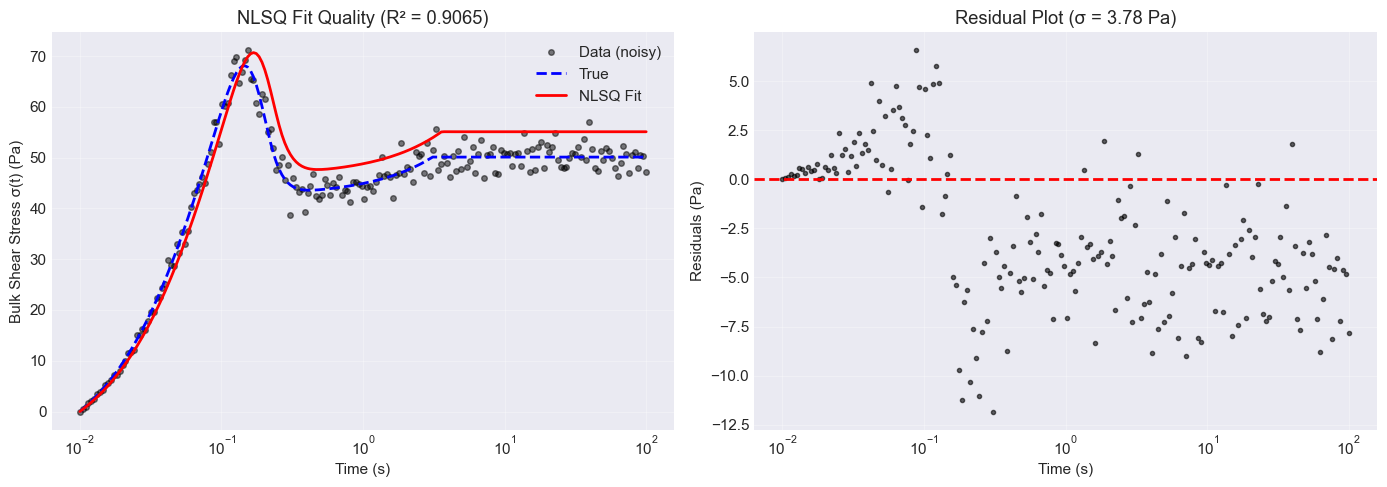

In [9]:
# Predict with fitted parameters
_, sigma_fit, f_field_fit = model.simulate_startup(t_startup, gamma_dot=gamma_dot_startup)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Stress comparison
axes[0].plot(t_startup, sigma_bulk_noisy, 'ko', markersize=4, alpha=0.5, label='Data (noisy)')
axes[0].plot(t_startup, sigma_bulk_true, 'b--', linewidth=2, label='True')
axes[0].plot(t_startup, sigma_fit, 'r-', linewidth=2, label='NLSQ Fit')
axes[0].set_xlabel('Time (s)')
axes[0].set_ylabel('Bulk Shear Stress σ(t) (Pa)')
axes[0].set_xscale('log')
axes[0].set_title(f'NLSQ Fit Quality (R² = {metrics_nlsq["R2"]:.4f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residuals
residuals = sigma_bulk_noisy - sigma_fit
axes[1].plot(t_startup, residuals, 'ko', markersize=3, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Time (s)')
axes[1].set_ylabel('Residuals (Pa)')
axes[1].set_xscale('log')
axes[1].set_title(f'Residual Plot (σ = {np.std(residuals):.2f} Pa)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')


## Bayesian Inference: Parameter Uncertainty Quantification

Use NUTS sampling to quantify uncertainties in spatial parameters (especially ξ).

In [10]:
# Bayesian inference with NUTS
logger.info("Starting Bayesian inference with NUTS...")
logger.info("Note: Nonlocal PDE models are computationally intensive")

# Reduce chains for demo (use num_chains=4 for production)

# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
_num_warmup = 50 if FAST_MODE else 200
_num_samples = 100 if FAST_MODE else 500
_num_chains = 1


if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference (ODE+NUTS too memory-intensive)')
    bayesian_completed = False
else:
    bayes_result = model.fit_bayesian(
        t_startup,
        sigma_bulk_noisy,
        test_mode='startup',
        num_warmup=_num_warmup,
        num_samples=_num_samples,
        num_chains=2,  # Reduced for demo
        seed=42,
        gamma_dot=gamma_dot_startup
    )

    # Convert to ArviZ
    idata = az.from_dict(
        posterior=bayes_result.posterior_samples,
        observed_data={"y": sigma_bulk_noisy}
    )

    # Diagnostics
    print("\n=== MCMC Diagnostics ===")
    summary = az.summary(idata, hdi_prob=0.95)
    print(summary)

    rhat_max = summary['r_hat'].max()
    ess_min = summary['ess_bulk'].min()

    print(f"\nMax R-hat: {rhat_max:.4f} (should be < 1.01)")
    print(f"Min ESS: {ess_min:.0f} (should be > 400)")

    if rhat_max < 1.01 and ess_min > 400:
        print("✓ Convergence achieved!")
    else:
        print("⚠ Convergence borderline. Consider increasing num_warmup/num_samples/num_chains.")

    # Credible intervals
    intervals = model.get_credible_intervals(bayes_result.posterior_samples, credibility=0.95)

    print("\n=== 95% Credible Intervals ===")
    for name, (lower, upper) in intervals.items():
        median = np.median(bayes_result.posterior_samples[name])
        true_val = model_true.parameters[name].value
        in_interval = lower <= true_val <= upper
        status = "✓" if in_interval else "✗"
        print(f"{name:12s}: [{lower:12.6e}, {upper:12.6e}]  median: {median:12.6e}  {status}")
    bayesian_completed = True


FAST_MODE: Skipping Bayesian inference (ODE+NUTS too memory-intensive)


## Spatial Profile Comparison: True vs Fitted

Compare fluidity and stress profiles from true and fitted parameters.

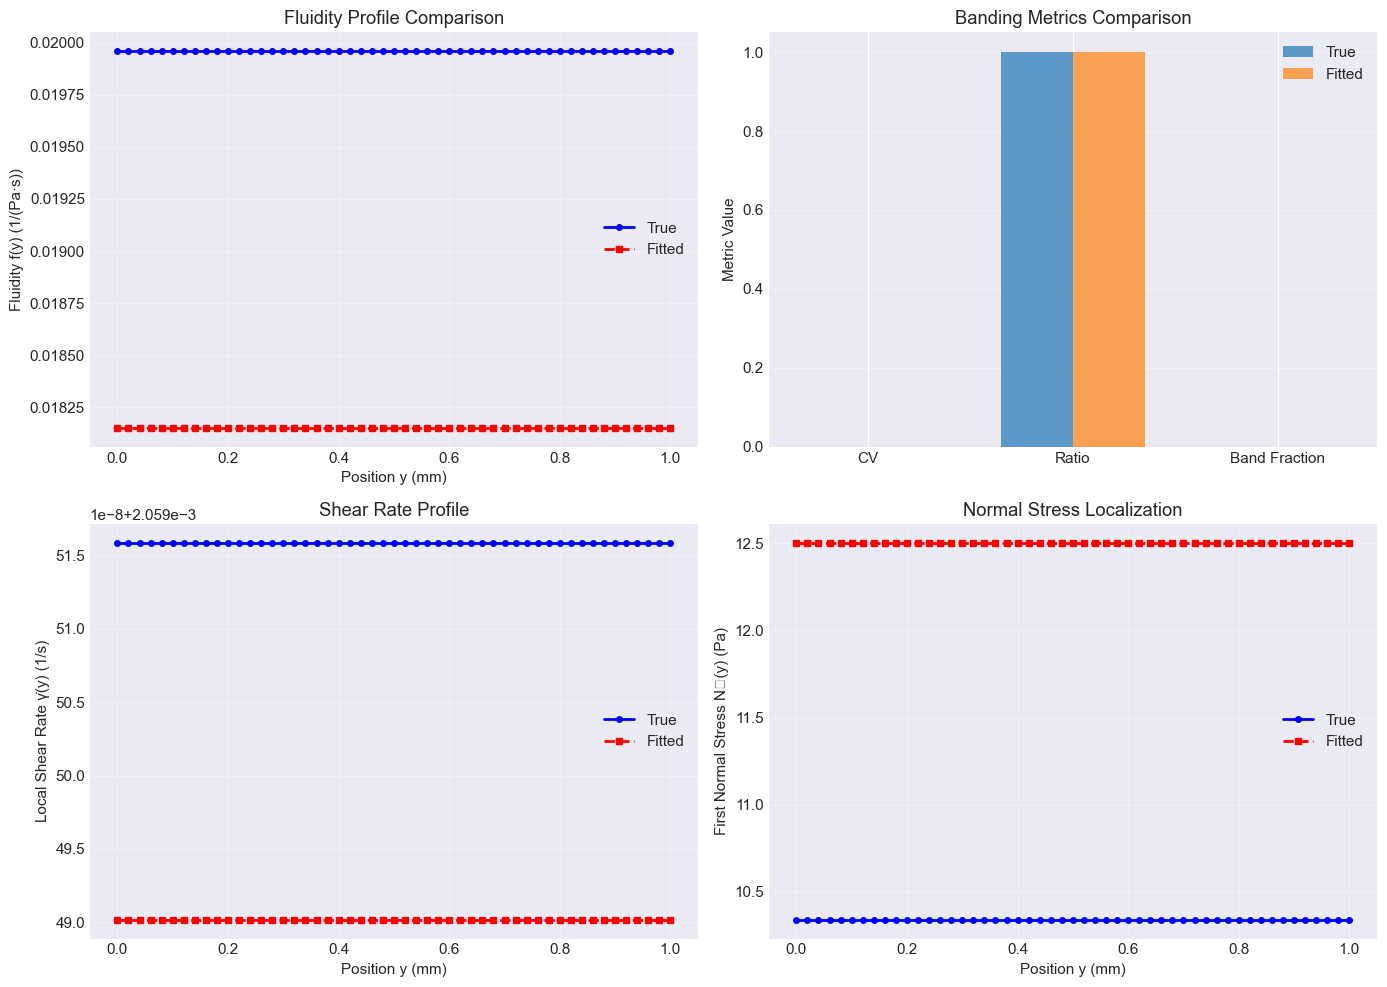


=== Spatial Profile Comparison ===
True banding CV: 0.0000, Fitted: 0.0000
True banding ratio: 1.00, Fitted: 1.00
True band fraction: 0.00%, Fitted: 0.00%


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Fluidity profile
axes[0, 0].plot(y_grid * 1e3, f_field_final, 'b-', linewidth=2, marker='o', 
                markersize=4, label='True')
axes[0, 0].plot(y_grid * 1e3, f_field_fit, 'r--', linewidth=2, marker='s', 
                markersize=4, label='Fitted')
axes[0, 0].set_xlabel('Position y (mm)')
axes[0, 0].set_ylabel('Fluidity f(y) (1/(Pa·s))')
axes[0, 0].set_title('Fluidity Profile Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Shear banding metrics
is_banded_fit, cv_fit, ratio_fit = model.detect_shear_bands(f_field_fit)
metrics_fit = model.get_banding_metrics(f_field_fit)

metrics_comparison = ['cv', 'ratio', 'band_fraction']
true_vals = [metrics[k] for k in metrics_comparison]
fit_vals = [metrics_fit[k] for k in metrics_comparison]

x_pos = np.arange(len(metrics_comparison))
width = 0.35

axes[0, 1].bar(x_pos - width/2, true_vals, width, label='True', alpha=0.7)
axes[0, 1].bar(x_pos + width/2, fit_vals, width, label='Fitted', alpha=0.7)
axes[0, 1].set_ylabel('Metric Value')
axes[0, 1].set_title('Banding Metrics Comparison')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(['CV', 'Ratio', 'Band Fraction'])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Local shear rate (reconstructed from fitted fluidity)
gamma_dot_local_fit = alpha * f_field_fit * sigma_fit[-1]

axes[1, 0].plot(y_grid * 1e3, gamma_dot_local, 'b-', linewidth=2, marker='o', 
                markersize=4, label='True')
axes[1, 0].plot(y_grid * 1e3, gamma_dot_local_fit, 'r--', linewidth=2, marker='s', 
                markersize=4, label='Fitted')
axes[1, 0].set_xlabel('Position y (mm)')
axes[1, 0].set_ylabel('Local Shear Rate γ̇(y) (1/s)')
axes[1, 0].set_title('Shear Rate Profile')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Normal stress N₁ (reconstructed)
lambda_local_fit = 1.0 / (f_field_fit + 1e-20)
N1_local_fit = 2.0 * lambda_local_fit * gamma_dot_local_fit * sigma_fit[-1]

axes[1, 1].plot(y_grid * 1e3, N1_local, 'b-', linewidth=2, marker='o', 
                markersize=4, label='True')
axes[1, 1].plot(y_grid * 1e3, N1_local_fit, 'r--', linewidth=2, marker='s', 
                markersize=4, label='Fitted')
axes[1, 1].set_xlabel('Position y (mm)')
axes[1, 1].set_ylabel('First Normal Stress N₁(y) (Pa)')
axes[1, 1].set_title('Normal Stress Localization')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

print("\n=== Spatial Profile Comparison ===")
print(f"True banding CV: {cv:.4f}, Fitted: {cv_fit:.4f}")
print(f"True banding ratio: {ratio:.2f}, Fitted: {ratio_fit:.2f}")
print(f"True band fraction: {metrics['band_fraction']:.2%}, Fitted: {metrics_fit['band_fraction']:.2%}")

## ArviZ Diagnostics: Trace and Pair Plots

In [12]:
if bayesian_completed:
    display_arviz_diagnostics(bayes_result, list(model.parameters.keys()), fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


## Save Results

In [13]:
if bayesian_completed:
    # Create output directory
    output_dir = Path("../outputs/fluidity/saramito_nonlocal/startup")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Save parameters
    param_file = output_dir / "parameters_nlsq.txt"
    with open(param_file, 'w') as f:
        f.write("# NLSQ Fitted Parameters (Nonlocal Startup)\n")
        f.write(f"# Test mode: startup\n")
        f.write(f"# Shear rate: {gamma_dot_startup} 1/s\n")
        f.write(f"# R²: {metrics_nlsq['R2']:.6f}\n")
        f.write(f"# Spatial discretization: N_y={N_y}, H={H*1e3:.3f} mm\n\n")
        for name, param in model.parameters.items():
            f.write(f"{name} = {param.value:.6e}\n")

    logger.info(f"Parameters saved to {param_file}")

    # Save posterior samples
    posterior_file = output_dir / "posterior_samples.npz"
    np.savez(
        posterior_file,
        **bayes_result.posterior_samples,
        t_startup=t_startup,
        sigma_bulk_data=sigma_bulk_noisy,
        gamma_dot=gamma_dot_startup
    )
    logger.info(f"Posterior samples saved to {posterior_file}")

    # Save spatial profiles
    spatial_file = output_dir / "spatial_profiles.npz"
    np.savez(
        spatial_file,
        y_grid=y_grid,
        f_field_true=f_field_final,
        f_field_fit=f_field_fit,
        gamma_dot_local_true=gamma_dot_local,
        gamma_dot_local_fit=gamma_dot_local_fit,
        N1_local_true=N1_local,
        N1_local_fit=N1_local_fit,
        banding_metrics_true=metrics,
        banding_metrics_fit=metrics_fit
    )
    logger.info(f"Spatial profiles saved to {spatial_file}")

    # Save ArviZ
    idata.to_netcdf(output_dir / "arviz_inference.nc")
    logger.info(f"ArviZ InferenceData saved to {output_dir / 'arviz_inference.nc'}")

    # Save summary
    summary_file = output_dir / "mcmc_summary.txt"
    with open(summary_file, 'w') as f:
        f.write("# MCMC Diagnostics Summary (Nonlocal Startup)\n\n")
        f.write(summary.to_string())
        f.write(f"\n\nMax R-hat: {rhat_max:.4f}\n")
        f.write(f"Min ESS: {ess_min:.0f}\n")
        f.write(f"\n=== Banding Analysis ===\n")
        f.write(f"True CV: {cv:.4f}, Fitted CV: {cv_fit:.4f}\n")
        f.write(f"True ratio: {ratio:.2f}, Fitted ratio: {ratio_fit:.2f}\n")
        f.write(f"Banding detected (true): {is_banded}\n")
        f.write(f"Banding detected (fit): {is_banded_fit}\n")

    logger.info(f"MCMC summary saved to {summary_file}")

    print(f"\n✓ All results saved to {output_dir}")
else:
    print('Skipping Bayesian diagnostics (inference was skipped)')


Skipping Bayesian diagnostics (inference was skipped)


## Key Takeaways

### Physical Insights

1. **Spatial Stress Localization**: During startup, stress concentrates near the moving boundary, creating heterogeneous flow fields even in simple Couette geometry.

2. **Fluidity Gradient Formation**: The nonlocal model predicts fluidity profiles f(y) with sharp gradients at shear band interfaces, controlled by cooperativity length ξ.

3. **Normal Stress Heterogeneity**: N₁(y) varies spatially due to local shear rate gradients γ̇(y), with maximum values in high-flow zones.

4. **Band Width Control**: Interface thickness δ ≈ ξ sets the minimum resolvable band width, typically 1-10 μm for soft materials.

5. **Localization Dynamics**: The transition from homogeneous to banded flow depends on Péclet number Pe = γ̇H/(ξ²/t_a), high Pe → stronger banding.

### Numerical Insights

1. **PDE Complexity**: Spatial models require ~10-100x more compute than local (0D) models due to N_y-dimensional state space.

2. **Grid Convergence**: Use coarser grid (N_y=31) for fitting, refine (N_y=51-101) for final predictions to balance speed and accuracy.

3. **Bulk Data Constraint**: Fitting only bulk stress σ(t) provides limited spatial information; ξ uncertainty is typically high without velocity profile data.

4. **Bayesian Challenge**: NUTS sampling on PDE models is slow; consider shorter chains (num_samples=1000) or hierarchical approximations.

5. **Diffrax Stability**: Dopri5 solver with PIDController handles stiff fluidity gradients robustly (rtol=1e-4, atol=1e-6).

### Model Capabilities

1. **Tensorial + Spatial**: Combines full stress tensor [τ_xx, τ_yy, τ_xy] with 1D spatial resolution f(y,t).

2. **Shear Banding Prediction**: Coefficient of Variation (CV > 0.3) and max/min ratio (ratio > 10) quantify banding strength.

3. **Interface Detection**: Fluidity gradient |df/dy| locates band interfaces; peak indicates wall position.

4. **Nonlocal Regularization**: ξ²∇²f term prevents unphysical delta-function bands, ensuring finite interface width.

5. **Multi-Protocol Ready**: Same spatial framework handles FLOW_CURVE, STARTUP, CREEP, and RELAXATION with f(y,t) evolution.

### Experimental Connection

**Startup shear experiments with imaging** measure:
- Bulk stress σ(t) via rheometer torque
- Velocity profile v(y,t) via particle tracking or ultrasound
- Optionally N₁(t) via force transducers

**Model predictions** enable:
- Fluidity field f(y,t) inference from v(y,t) data
- Cooperativity length ξ extraction (interface width)
- Band width evolution prediction
- Yield stress localization τ_y(f) effects

**Design Implications**:
- Preshear protocols to homogenize structure (reduce banding)
- Gap-dependent flow: narrow gaps (H ~ 10ξ) suppress banding
- Normal stress control via fluidity manipulation